
# Validation of the simulation environment

## Purpose
In this exercise, our goal is to replicate Figure 3.2 from Raphaël Gass's thesis manuscript, which shows a polarization curve for a Proton Exchange Membrane (PEM) fuel cell at a pressure of 1.5 bar. We will use the AlphaPEM model to simulate this curve under the specified conditions. This will help us verify the simulation environment and ensure that our model is correctly set up. 

Figure 3.2 in the thesis manuscript presents a polarization curve, which illustrates how the cell voltage varies with current density, for a PEM fuel cell operating at a pressure of 1.5 bar. 

In [1]:
import os, sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml
from copy import deepcopy
from scipy.interpolate import interp1d

In [2]:
PARENT = ".."

sys.path.append(PARENT)
from src.sampling.sampler import run_alphapem_from_df

We first load the data from two sources: Figure 3.2 from the manuscript and GUI EH-31 with 1.5 bar for anode and cathode pressure. This data was extracted using an online tool (see [WebPlotDigitizer](https://automeris.io/wpd/?v=5_2)).

In [3]:
PARAM_CONFIG_YAML = f"{PARENT}/configs/param_config.yaml"
SIM_DEFAULTS_YAML = f"{PARENT}/configs/simulator_defaults.yaml"
ALPHAPEM_ROOT     = f"{PARENT}/external/AlphaPEM"

# Paths for the csv files of the GUI and manuscript plots (extracted using the tool)
MANUSCRIPT_FIG32_CSV = f"{PARENT}/data/external/fig3.2_blue_1.5_pressure.csv"
GUI_FIG32_CSV        = f"{PARENT}/data/external/version1.0/fig3.2_fromGUI_1.5_pressure_v1.0.csv"

MANUSCRIPT_FIG31_20  = f"{PARENT}/data/external/fig3.1_orange_2.0_pressure.csv"
GUI_FIG31_20         = f"{PARENT}/data/external/version1.0/fig3.1_fromGUI_2.0_pressure_v1.0.csv"

MANUSCRIPT_FIG31_225 = f"{PARENT}/data/external/fig3.1_green_2.25_pressure.csv"
GUI_FIG31_225        = f"{PARENT}/data/external/version1.0/fig3.1_fromGUI_2.25_pressure_v1.0.csv"

MANUSCRIPT_FIG31_25  = f"{PARENT}/data/external/fig3.1_red_2.5_pressure.csv"
GUI_FIG31_25         = f"{PARENT}/data/external/version1.0/fig3.1_fromGUI_2.5_pressure_v1.0.csv"

OUTPUT_DIR = f"{PARENT}/data/raw"
RUN_NAME   = "replication_figs_v1"

### Utils

In [4]:
def make_curve_df(x, y):
    df = pd.DataFrame({
        "Current Density (A/cm²)": np.asarray(x, dtype=float),
        "Cell Voltage (V)":        np.asarray(y, dtype=float),
    }).dropna()
    df = df.sort_values("Current Density (A/cm²)").drop_duplicates(
        subset=["Current Density (A/cm²)"], keep="first"
    )
    return df

def load_curve_csv(path):
    d = pd.read_csv(path, delimiter=";", decimal=",", names=["x","y"])
    return make_curve_df(d["x"].to_numpy(), d["y"].to_numpy())

def row_to_curve(df: pd.DataFrame):
    r = df.iloc[0]
    ifc_cols = [c for c in df.columns if c.startswith("ifc_")]
    u_cols   = [c for c in df.columns if c.startswith("Ucell_")]
    ifc = r[ifc_cols].astype(float).to_numpy()
    u   = r[u_cols].astype(float).to_numpy()
    mask = ~(np.isnan(ifc) | np.isnan(u))
    return ifc[mask], u[mask]

To quantify the difference between the manuscript and our replica polarization curves, we need a function that interpolates the manuscript's voltage values at the current density points used in our replica (since the x-values do not necessarily align). We can then compute the maximum absolute difference in voltage between the interpolated manuscript curve and our replica to assess the deviation.

In [5]:
def compare_curves(manuscript_df, replica_df):
    """
    Interpolate manuscript onto replica x-grid, but only compare up to
    the manuscript's max current density (crop the replica tail).
    Returns (max_abs_error, mae, rmse, replica_cropped_df).
    """
    manuscript_df = manuscript_df.sort_values("Current Density (A/cm²)")
    replica_df    = replica_df.sort_values("Current Density (A/cm²)")

    max_i_manuscript = float(manuscript_df["Current Density (A/cm²)"].max())
    replica_cropped  = replica_df[replica_df["Current Density (A/cm²)"] <= max_i_manuscript]
    if len(replica_cropped) == 0:
        raise ValueError("Replica curve has no points within manuscript support.")

    interp_func = interp1d(
        manuscript_df["Current Density (A/cm²)"].to_numpy(),
        manuscript_df["Cell Voltage (V)"].to_numpy(),
        kind="linear",
        bounds_error=False,
        fill_value="extrapolate",
        assume_sorted=True,
    )
    interp_voltages = interp_func(replica_cropped["Current Density (A/cm²)"].to_numpy())

    errors = np.abs(interp_voltages - replica_cropped["Cell Voltage (V)"].to_numpy())
    max_abs_error = float(np.max(errors))
    mae = float(np.mean(errors))
    rmse = float(np.sqrt(np.mean(errors**2)))
    return max_abs_error, mae, rmse, replica_cropped


## Simulation conditions
Here are the sources for the simulation conditions used for Fig. 3.2:

1. Operating Conditions: Table 3.3 (Manufacturer operating conditions).
2. Physical Parameters: Table 3.2 (Accessible physical parameters).
3. Undetermined Physical Parameters: Table 3.4 (Calibrated undetermined parameters).
4. Pressure: Figure 3.2 caption and description.

Here, we define the experimental conditions.

In [6]:
def build_design_row(pressure_pa: float) -> pd.DataFrame:
    row = {
        "config_id": f"rep_{int(round(pressure_pa/1e3))}kPa",

        # Operating conditions 
        "Tfc": 347.15,               # Important: In Kelvin. In GUI, °C are used
        "Pa_des": pressure_pa,       # Important: Converted from bar to pascal (1 bar = 10**5 Pa)
        "Pc_des": pressure_pa,
        "Sa": 1.2,
        "Sc": 2.0,
        "Phi_a_des": 0.4,
        "Phi_c_des": 0.6,

        # Accessible physical parameters
        "Aact": 8.5e-3,             # Note: Here, in m^2. In GUI, in cm^2
        "Hmem": 2e-5,
        "Hcl":  1e-5,
        "Hgdl": 2e-4,
        "Hgc":  5e-4,
        "Wgc":  4.5e-4,
        "Lgc":  9.67,
        
        # Undetermined physical parameters
        "i0_c_ref": 2.79,
        "kappa_co": 27.2,
        "kappa_c":  1.61,
        "tau": 1.016,                # Changed to match GUI (from 1.02 to 1.016)
        "epsilon_mc": 0.399,
        "Re": 5.70e-7,
        "e": 5,
        "epsilon_c":  0.271,
        "epsilon_gdl": 0.701,
        "a_slim": 0.05553,          # Changed to match the GUI (went from 0.056 to 0.05553)
        "b_slim": 0.10514,          # Added some decimal digits (from 0.105 to 0.10514) to match GUI
        "a_switch": 0.63654,        # Changed to match GUI (from 0.637 to 0.63654)
        "C_scl": 2e7,               # Default value at page 145
    }
    return pd.DataFrame([row])

The model possibilities were extracted from the GUI options (set as default when one chooses the EH-31 fuel cell with pressure of 1.5). 

In [7]:
def write_defaults_with_overrides(base_yaml_path, out_yaml_path, overrides: dict):
    base = {}
    p = Path(base_yaml_path)
    if p.exists():
        with open(p, "r", encoding="utf-8") as f:
            base = yaml.safe_load(f) or {}
    merged = deepcopy(base)
    for k, v in overrides.items():
        merged[k] = v
    Path(out_yaml_path).parent.mkdir(parents=True, exist_ok=True)
    with open(out_yaml_path, "w", encoding="utf-8") as f:
        yaml.safe_dump(merged, f, sort_keys=False)
    return str(out_yaml_path)

GUI_MODEL_FLAGS = {
    "type_fuel_cell": "manual_setup",
    "type_current": "polarization",
    "type_auxiliary": "forced-convective_cathode_with_flow-through_anode",
    "type_control": "no_control",
    "type_purge": "no_purge",
    "type_display": "synthetic",
    "type_plot": "fixed",
}

SIM_DEFAULTS_YAML_GUI = write_defaults_with_overrides(
    SIM_DEFAULTS_YAML,
    Path(SIM_DEFAULTS_YAML).with_name("simulator_defaults_gui_like.yaml"),
    GUI_MODEL_FLAGS,
)

## Replication of figure 3.2: Comparison between manuscript's version and our replica

First, we run AlphaPEM on the simulation conditions that were previously defined.

Here we build a demo row with the complete configuration (using Pa = 1.5 bar), then feed it directly to our main simulator wrapper `run_alphapem_from_df`. This function takes care of validation (if enabled), calling the AlphaPEM backend, collecting outputs (`ifc`, `Ucell`, and their expanded columns), and optionally saving results. Here, we only return them.

In [8]:
demo_df = build_design_row(1.5e5)
results = run_alphapem_from_df(
    demo_df,
    alpha_pem_root=ALPHAPEM_ROOT,
    simulator_defaults_yaml=SIM_DEFAULTS_YAML_GUI,  # GUI-like flags
    param_config_yaml=PARAM_CONFIG_YAML,
    verify=False,                                   # keep Pa==Pc regardless of YAML derivation
    run_name=RUN_NAME + "_1p5bar",
    save_every=1,
    save_results=False
)

[INFO] Running AlphaPEM on 1 configuration(s)...


Now, we plot the three curves (manuscript, GUI version and our replica) and quantify their differences.

[Manuscript] max=0.0234 V | MAE=0.0028 V | RMSE=0.0057 V
[GUI v1.0]  max=0.0016 V | MAE=0.0006 V | RMSE=0.0008 V


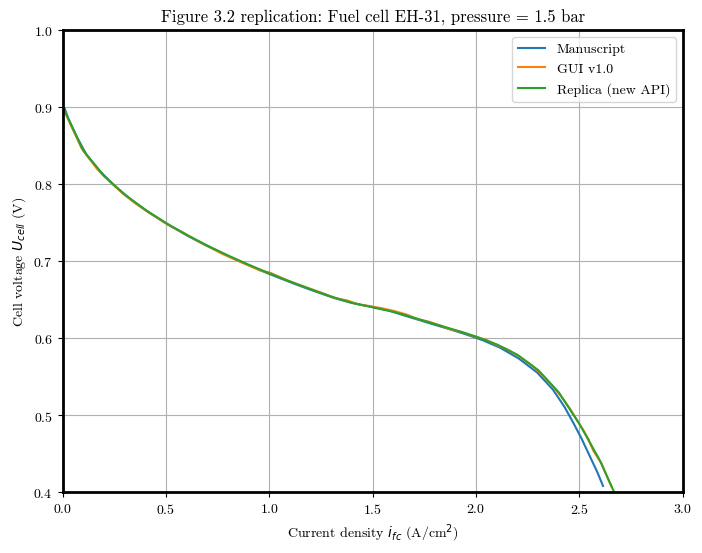

In [9]:
# Curves: sim, manuscript, GUI
x_sim, y_sim = row_to_curve(results)
replica_df = make_curve_df(x_sim, y_sim)

manuscript_df = load_curve_csv(MANUSCRIPT_FIG32_CSV) if Path(MANUSCRIPT_FIG32_CSV).exists() else None
gui_df        = load_curve_csv(GUI_FIG32_CSV)        if Path(GUI_FIG32_CSV).exists()        else None

# Metrics (vs manuscript + vs GUI if available)
if manuscript_df is not None:
    mx_m, mae_m, rmse_m, replica_crop_m = compare_curves(manuscript_df, replica_df)
    print(f"[Manuscript] max={mx_m:.4f} V | MAE={mae_m:.4f} V | RMSE={rmse_m:.4f} V")
else:
    replica_crop_m = None
    print("Manuscript CSV not found, skipped manuscript metrics.")

if gui_df is not None:
    mx_g, mae_g, rmse_g, replica_crop_g = compare_curves(gui_df, replica_df)
    print(f"[GUI v1.0]  max={mx_g:.4f} V | MAE={mae_g:.4f} V | RMSE={rmse_g:.4f} V")
else:
    replica_crop_g = None
    print("GUI CSV not found, skipped GUI metrics.")

# Plot overlay (Manuscript + GUI + Replica)
plt.figure(figsize=(8,6))
if manuscript_df is not None:
    plt.plot(manuscript_df["Current Density (A/cm²)"], manuscript_df["Cell Voltage (V)"], label="Manuscript")
if gui_df is not None:
    plt.plot(gui_df["Current Density (A/cm²)"], gui_df["Cell Voltage (V)"], label="GUI v1.0")
plt.plot(replica_df["Current Density (A/cm²)"], replica_df["Cell Voltage (V)"], label="Replica (new API)")
plt.title("Figure 3.2 replication: Fuel cell EH-31, pressure = 1.5 bar")
plt.xlabel("Current density $i_{fc}$ (A/cm$^{2}$)")
plt.ylabel("Cell voltage $U_{cell}$ (V)")
plt.xlim(0, 3)
plt.ylim(0.4, 1)
plt.grid(True)
plt.legend(loc="best")
plt.show()

### Conclusions

In order to obtain the same polarization plot as the GUI, some of the parameters had to be adjusted. Here are the changes made to the parameters:

| Type of Parameter       | Name (in code)               | Previous Value | New Value      |
|-------------------------|--------------------------------|-----------------|----------------|
| Undetermined Physical  | tau                           | 1.02            | 1.016          |
| Undetermined Physical  | a_slim                        | 0.056           | 0.05553        |
| Undetermined Physical  | b_slim                        | 0.105           | 0.10514        |
| Undetermined Physical  | a_switch                      | 0.637           | 0.63654        |
| Model Possibilities     | type_fuel_cell                | manual_setup    | EH-31_1.5      |
| Model Possibilities     | type_auxiliary                | no_auxiliary    | forced-convective_cathode_with_flow-through_anode |
| Model Possibilities     | type_display                 | no_display      | synthetic      |

Note: At least from visual inspection, the parameter that had the most significant impact was the type_auxiliary. This parameter and its possible values need to be studied, so that we can understand why setting it to "no_auxiliary" leads to negative voltage values*. 

*) Could this be the reason we are getting negative results in the other samples?

On the other hand, there is a clear difference between the polarization curves from the manuscript and those who were reproduced here. The reason is still unknown to me, since all the parameters match the values presented in the manuscript. I saw that Gass made some updates to the repository since the publication of the thesis and paper, so this is perhaps why?

## Replication of figure 3.1: Pressure of 2.0, 2.25 and 2.5 bar for a EH-31 fuel cell

We will now try to reproduce the polarization curves presented in the figure 3.1 of the thesis manuscript. These share the same experimental conditions that figure 3.2 has, except for the pressure of anode and cathode (which is here set to 2, 2.25 or 2.5 bar).

In [ ]:
def run_and_compare(pressure_pa, manuscript_csv=None, gui_csv=None, tag=""):
    df = build_design_row(pressure_pa)
    out = run_alphapem_from_df(
        df,
        alpha_pem_root=ALPHAPEM_ROOT,
        simulator_defaults_yaml=SIM_DEFAULTS_YAML_GUI,
        param_config_yaml=PARAM_CONFIG_YAML,
        verify=False,
        run_name=f"{RUN_NAME}_{tag}",
        save_every=1,
        print_errors=True,
        save_results=False
    )
    x_sim, y_sim = row_to_curve(out)
    replica_df = make_curve_df(x_sim, y_sim)

    ms_df = load_curve_csv(manuscript_csv) if (manuscript_csv and Path(manuscript_csv).exists()) else None
    g_df  = load_curve_csv(gui_csv)        if (gui_csv and Path(gui_csv).exists()) else None

    print("--------------------------------------------------\n ERROR METRICS\n")
    if ms_df is not None:
        mx_m, mae_m, rmse_m, rep_crop_m = compare_curves(ms_df, replica_df)
        print(f"[{pressure_pa/1e5:.2f} bar vs Manuscript] max={mx_m:.4f} | MAE={mae_m:.4f} | RMSE={rmse_m:.4f}")
    if g_df is not None:
        mx_g, mae_g, rmse_g, rep_crop_g = compare_curves(g_df, replica_df)
        print(f"[{pressure_pa/1e5:.2f} bar vs GUI]        max={mx_g:.4f} | MAE={mae_g:.4f} | RMSE={rmse_g:.4f}")

    plt.figure(figsize=(8,6))
    if ms_df is not None:
        plt.plot(ms_df["Current Density (A/cm²)"], ms_df["Cell Voltage (V)"], label="Manuscript")
    if g_df is not None:
        plt.plot(g_df["Current Density (A/cm²)"], g_df["Cell Voltage (V)"], label="GUI v1.0")
    plt.plot(replica_df["Current Density (A/cm²)"], replica_df["Cell Voltage (V)"], label="Replica (new API)")
    plt.title(f"Figure 3.1 replication: EH-31 fuel cell, pressure = {pressure_pa/1e5:.2f} bar")
    plt.xlabel("Current density $i_{fc}$ (A/cm$^{2}$)")
    plt.ylabel("Cell voltage $U_{cell}$ (V)")
    plt.xlim(0, 3)
    plt.ylim(0.4, 1)
    plt.grid(True)
    plt.legend(loc="best")
    plt.show()

[INFO] Running AlphaPEM on 1 configuration(s)...
--------------------------------------------------
 ERROR METRICS

[2.00 bar vs Manuscript] max=0.0159 | MAE=0.0043 | RMSE=0.0060
[2.00 bar vs GUI]        max=0.0010 | MAE=0.0004 | RMSE=0.0004


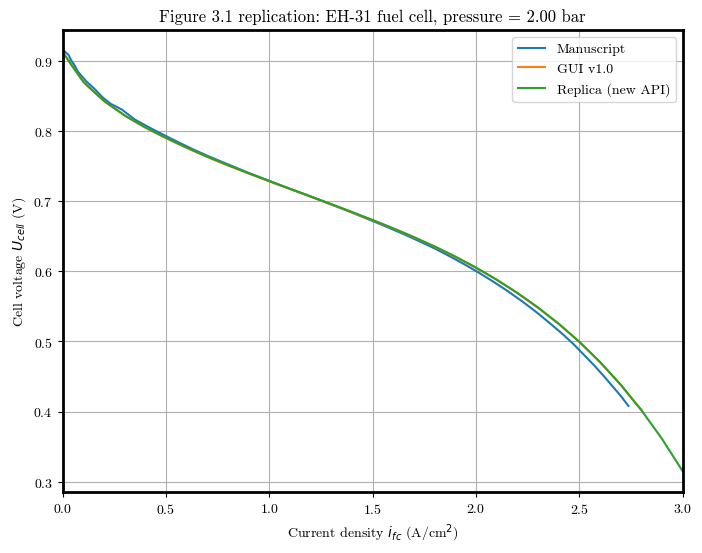

In [11]:
run_and_compare(2.0e5, MANUSCRIPT_FIG31_20,  GUI_FIG31_20,  tag="2p0bar")

[INFO] Running AlphaPEM on 1 configuration(s)...
--------------------------------------------------
 ERROR METRICS

[2.25 bar vs Manuscript] max=0.0103 | MAE=0.0035 | RMSE=0.0045
[2.25 bar vs GUI]        max=0.0021 | MAE=0.0007 | RMSE=0.0008


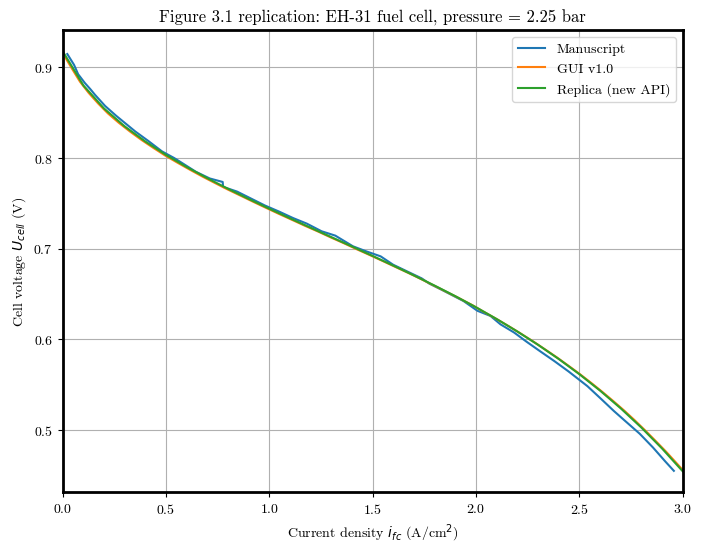

In [12]:
run_and_compare(2.25e5, MANUSCRIPT_FIG31_225, GUI_FIG31_225, tag="2p25bar")

[INFO] Running AlphaPEM on 1 configuration(s)...
--------------------------------------------------
 ERROR METRICS

[2.50 bar vs Manuscript] max=0.0074 | MAE=0.0022 | RMSE=0.0028
[2.50 bar vs GUI]        max=0.0014 | MAE=0.0006 | RMSE=0.0006


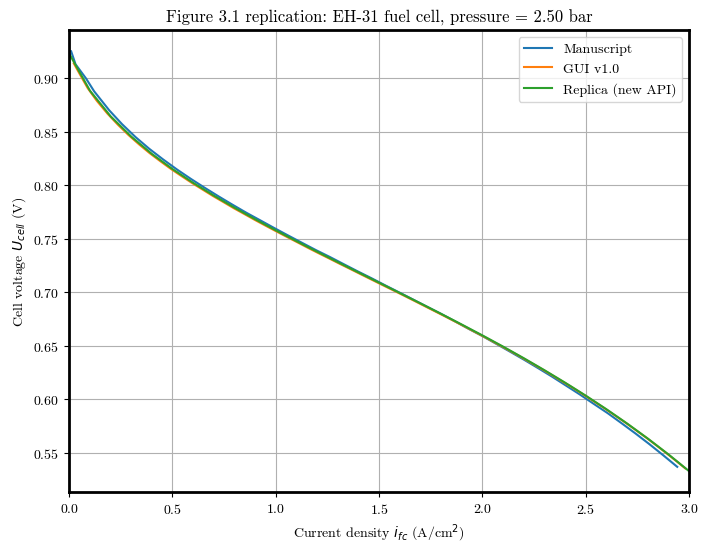

In [13]:
run_and_compare(2.5e5, MANUSCRIPT_FIG31_25,  GUI_FIG31_25,  tag="2p5bar")

As it is only needed for this exercise, we delete the simulator defaults from the GUI. 

In [14]:
# Clean up the temporary GUI-like defaults file
try:
    Path(SIM_DEFAULTS_YAML_GUI).unlink()
    print(f"Deleted temporary file: {SIM_DEFAULTS_YAML_GUI}")
except FileNotFoundError:
    print("Temporary GUI defaults file already removed.")

Deleted temporary file: ..\configs\simulator_defaults_gui_like.yaml


## Conclusions

The replication results show that our simulation environment is correct. The differences between our curves and the author's (both GUI and manuscript) are negligible and most likely come from minor inaccuracies in the data extraction process (as the data from the manuscript was derived using a tool), but not from the simulation itself. This confirms that our functions and setup can reliably reproduce the original results, so we can trust them for further work.